# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import os
import time
import pickle
import h5py
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import mask_util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Util.util import array2image
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import  plot_util
import paramiko
from astropy.io import fits
#from chainconsumer import Chain, ChainConsumer, PlotConfig # Need to double check the installation of chainconsumer

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/rosador/Documents/AGEL/Duncan_examples/model_notebooks


# Defining Functions

In [2]:
def import_data(filter):
    # get image data from .h5
    h5_file = os.path.join(base_path, '../data/image_DCLS0353-1706_{}.h5'.format(filter))
    f = h5py.File(h5_file, 'r')
    # storing data under correct keys
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    if filter == 'F200LP':
        data_file = os.path.join(base_path, '../data/DCLS0353-1706_{}.fits'.format(filter))
        f = fits.open(data_file)
        # storing data under correct keys
        kwargs_data.update({'image_data': f[0].data})
        f.close()

    # get PSF estimate from .h5
    psf_file = os.path.join(base_path, '../PSF files/psf_model_{}.h5'.format(filter))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    f.close()

    # format psf kwargs
    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

# setting band ra and dec shift relative to F200LP
kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

In [10]:
kwargs_data_F140W

{'background_rms': 0.01579632610083,
 'dec_at_xy_0': 2.1077615079456655,
 'dec_shift': 0.017099999999999997,
 'exposure_time': array([[376.14548, 306.65518, 309.79272, ..., 282.1858 , 418.4498 ,
         312.4237 ],
        [346.8679 , 340.8968 , 313.9651 , ..., 289.81232, 335.4434 ,
         315.2451 ],
        [448.45074, 359.57095, 378.58487, ..., 340.3743 , 423.93518,
         358.8697 ],
        ...,
        [355.1048 , 281.53015, 365.98083, ..., 335.8008 , 310.65347,
         220.43796],
        [386.65115, 348.0007 , 401.0427 , ..., 356.1663 , 309.21527,
         197.9228 ],
        [364.75443, 292.73322, 407.40005, ..., 197.40488, 267.22513,
         176.45721]], dtype='>f4'),
 'image_data': array([[0.02227715, 0.05319178, 0.04628062, ..., 0.064796  , 0.059681  ,
         0.04360098],
        [0.02737582, 0.05325899, 0.02861989, ..., 0.06979072, 0.04764354,
         0.04914558],
        [0.04499292, 0.03857645, 0.03312984, ..., 0.04799649, 0.04980755,
         0.04724371],
    

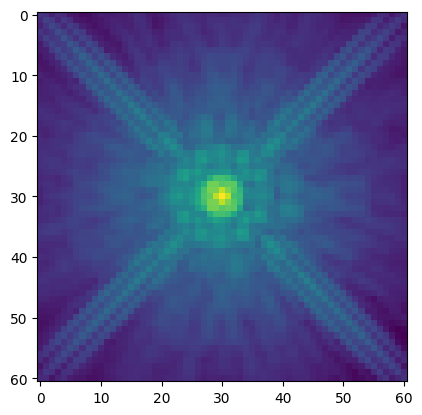

In [9]:
plt.imshow(np.log10(kwargs_psf_F140W['kernel_point_source']))

# Defining the Lens and Source Centers 

Pixel size: 0.05 arcsec
numPix: 110



/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33763/1487400407.py:18: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)


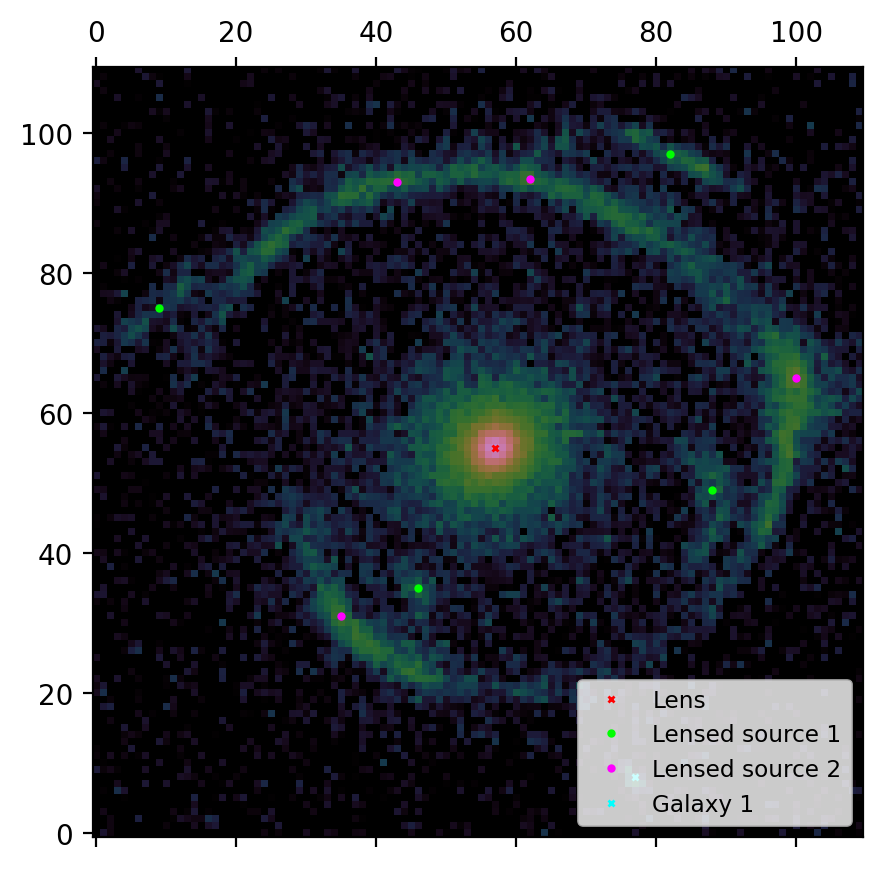

In [3]:
# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
image_data = kwargs_data_F200LP['image_data']
numPix = len(image_data)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
cmap.set_bad(color='k')
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid_F200LP = PixelGrid(**kwargs_pixel)
# plot_util.coordinate_arrows(ax, d=200, coords=pixel_grid, color='red', font_size=18, arrow_size=0.035)

# estimate lens position in pixel
lens_x_F200LP, lens_y_F200LP = 57, 55
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, 'x', color='red', ms = 2, label='Lens') 

# estimate source 1 positions in pixel
s1_x_F200LP = np.array([82,9,46,88])
s1_y_F200LP = np.array([97,75,35,49])
ra_image_s1_F200LP, dec_image_s1_F200LP = coords_F200LP.map_pix2coord(s1_x_F200LP, s1_y_F200LP)
ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 2, label='Lensed source 1')

# estimate source 2 positions in pixel
s2_x_F200LP = np.array([100,35,62,43])
s2_y_F200LP = np.array([65,31,93.5,93])
ra_image_s2_F200LP, dec_image_s2_F200LP = coords_F200LP.map_pix2coord(s2_x_F200LP, s2_y_F200LP)
ax.plot(s2_x_F200LP, s2_y_F200LP, 'o', color='magenta', ms = 2, label='Lensed source 2')


# estimate galaxy position in pixel
gal1_x_F200LP, gal1_y_F200LP = 77, 8
gal1_ra_F200LP, gal1_dec_F200LP = coords_F200LP.map_pix2coord(gal1_x_F200LP, gal1_y_F200LP)
ax.plot(gal1_x_F200LP, gal1_y_F200LP, 'x', color='cyan', ms = 2, label='Galaxy 1') 

plt.legend(loc='lower right', fontsize='small')
plt.show()

Pixel size: 0.08 arcsec
numPix: 68



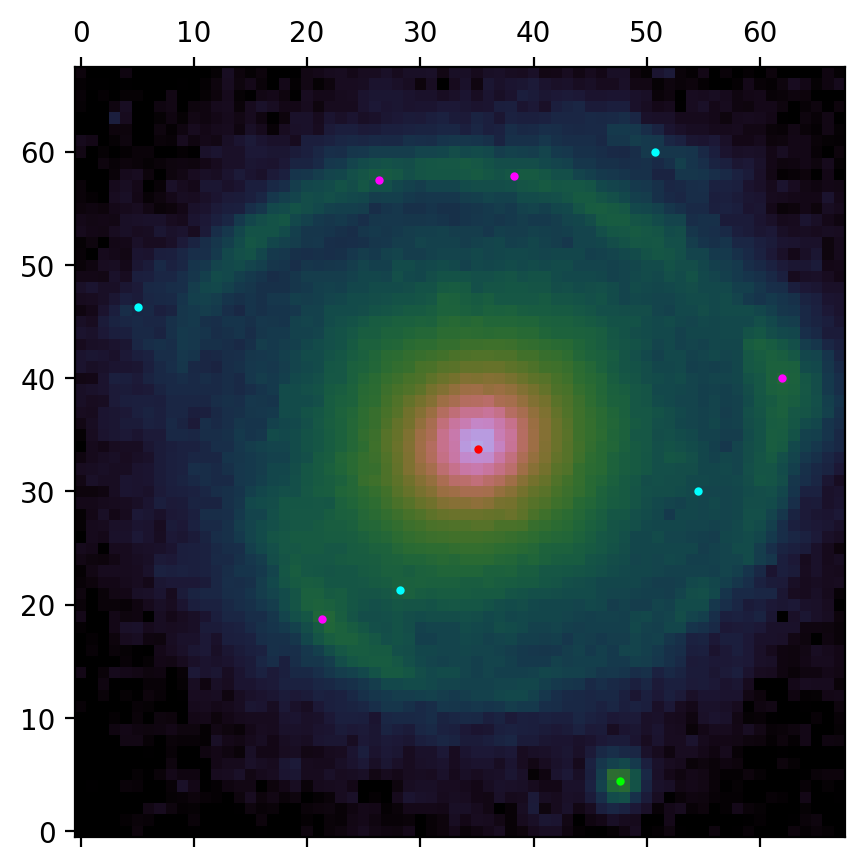

In [4]:
# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F140W['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F140W['dec_at_xy_0']
transform_pix2angle = kwargs_data_F140W['transform_pix2angle']
coords_F140W = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
image_data = kwargs_data_F140W['image_data']
numPix = len(image_data)
deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

cmap2 = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.6, dark=0.7, as_cmap=True)
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap=cmap2, vmin=-3.5, vmax=1.3, interpolation='None')

kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid_F140W = PixelGrid(**kwargs_pixel)
#plot_util.coordinate_arrows(ax, d=120, coords=pixel_grid, color='red', font_size=12, arrow_size=0.025)

# estimate lens position in pixel
lens_ra_F140W, lens_dec_F140W = lens_ra_F200LP+kwargs_data_F140W['ra_shift'], lens_dec_F200LP+kwargs_data_F140W['dec_shift']
lens_x_F140W, lens_y_F140W = coords_F140W.map_coord2pix(lens_ra_F140W, lens_dec_F140W)
ax.plot(lens_x_F140W, lens_y_F140W, 'o', color='red', ms = 2, label='Primary Lens') 

# estimate source 1 positions in pixel
ra_image_s1_F140W, dec_image_s1_F140W = ra_image_s1_F200LP+kwargs_data_F140W['ra_shift'], dec_image_s1_F200LP+kwargs_data_F140W['dec_shift']
s1_x_F140W, s1_y_F140W = coords_F140W.map_coord2pix(ra_image_s1_F140W, dec_image_s1_F140W)
ax.plot(s1_x_F140W, s1_y_F140W, 'o', color='cyan', ms = 2, label='Lensed Source 1')

# estimate source 2 positions in pixel
ra_image_s2_F140W, dec_image_s2_F140W = ra_image_s2_F200LP+kwargs_data_F140W['ra_shift'], dec_image_s2_F200LP+kwargs_data_F140W['dec_shift']
s2_x_F140W, s2_y_F140W = coords_F140W.map_coord2pix(ra_image_s2_F140W, dec_image_s2_F140W)
ax.plot(s2_x_F140W, s2_y_F140W, 'o', color='magenta', ms = 2, label='Lensed Source 2')

# estimate galaxy position in pixel
gal1_ra_F140W, gal1_dec_F140W=gal1_ra_F200LP+kwargs_data_F140W['ra_shift'], gal1_dec_F200LP+kwargs_data_F140W['dec_shift']
gal1_x_F140W,gal1_y_F140W=coords_F140W.map_coord2pix(gal1_ra_F140W, gal1_dec_F140W)
ax.plot(gal1_x_F140W,gal1_y_F140W, 'o', color='lime', ms = 2, label='Secondary Lens 1') 

# plt.legend(loc='upper left', fontsize='small', framealpha=0.9)
plt.show()

# Masking the fainter source

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33763/352639901.py:68: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33763/352639901.py:68: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33763/352639901.py:75: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)


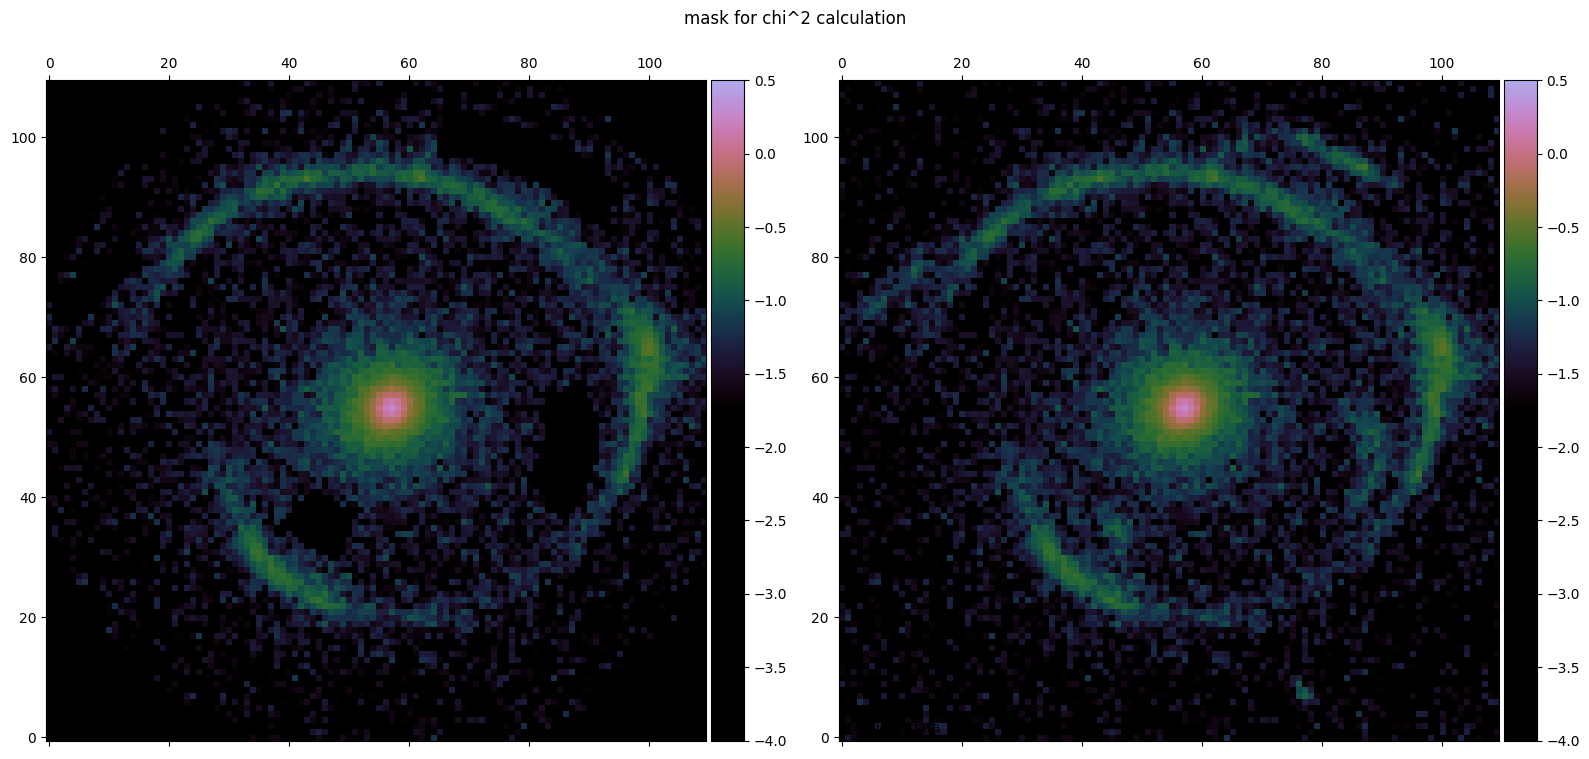

In [5]:
# creating mask
central_mask = False
central_mask_r = 1

# radius of circular aperture
r_mask_list = [[3]]  # list of mask radii for each mask band and filters eg [[filter1_rad1, filter1_rad2], [filter2_rad1, filter2_rad2]]

mask_list = []
index_mask_list = []

# lopping over no of bands
for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    # lopping over no of filters
    for j, kwargs_data in enumerate([kwargs_data_F200LP]): 
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        r = r_mask_list[j][i]
        mask_outer = mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, r, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
        
        # masking out second source
        #mask_arc1 = mask_util.mask_half_moon(util.image2array(x_coords)-0.24, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.6, 1.97, phi0=-0.1, delta_phi=0.9 * np.pi)
        #mask_arc2 = mask_util.mask_half_moon(util.image2array(x_coords)+0.155, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.88, 2.28, phi0=np.pi, delta_phi=0.84 * np.pi)
        #mask_arc3 = mask_util.mask_half_moon(util.image2array(x_coords)+0.155, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.88, 2.28, phi0=-np.pi, delta_phi=0.7 * np.pi)
        #mask_arc4 = mask_util.mask_half_moon(util.image2array(x_coords)-0.22, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.67, 2.4, phi0=0.52*np.pi, delta_phi=0.28 * np.pi)
        mask_gal1 = 1 - mask_util.mask_center_2d(gal1_ra_F200LP, gal1_dec_F200LP, 0.1, util.image2array(x_coords), util.image2array(y_coords))
        mask_arc5 = mask_util.mask_half_moon(util.image2array(x_coords)-0.22, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 2.1, 2.5, phi0=0.8*np.pi, delta_phi=0.22 * np.pi)
        mask_arc6 = mask_util.mask_half_moon(util.image2array(x_coords)+1, util.image2array(y_coords)-0.5, lens_ra_F200LP, lens_dec_F200LP, 2.2, 2.47, phi0=-0.83*np.pi, delta_phi=0.12 * np.pi)
        mask_arc7 = mask_util.mask_half_moon(util.image2array(x_coords)-0.8, util.image2array(y_coords)-0.45, lens_ra_F200LP, lens_dec_F200LP, 0.4, 0.85, phi0=0.4*np.pi, delta_phi=0.5 * np.pi)
        mask_arc8 = mask_util.mask_half_moon(util.image2array(x_coords)-0, util.image2array(y_coords)-0, lens_ra_F200LP, lens_dec_F200LP, 0.9, 1.35, phi0=-0.24*np.pi, delta_phi=0.15 * np.pi)

        mask = (1 - mask_outer) * (1 - mask_gal1) * (1 - mask_arc5) * (1 - mask_arc6) * (1 - mask_arc7) * (1 - mask_arc8) #* (1 - mask_arc1) * (1 - mask_arc2) * (1 - mask_arc3) * (1 - mask_arc4)
    
        # when modeling both sources    
        #mask = (1 - mask_outer) # now modeling both sources

        if central_mask:
            mask *= corona
        
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    
for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    image_data = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        plt.suptitle('mask for chi^2 calculation')
        im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.tight_layout()
        plt.show()

# Select the regions to be supersampled

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33763/3067902635.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')


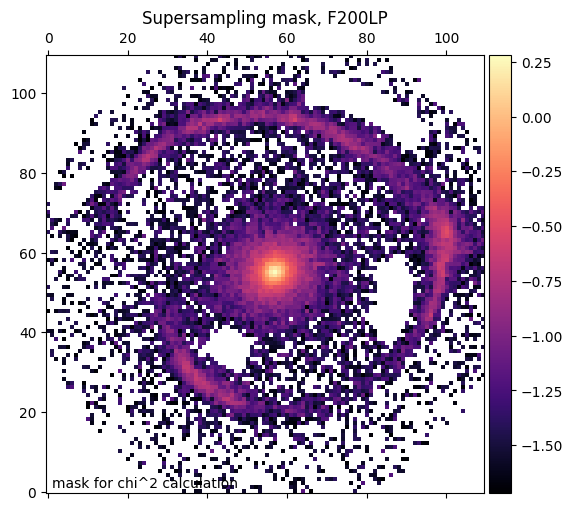

In [6]:
# pixels with flux > max_flux/threshold will not be supersampled
# here the threshold accepts pixels within 5 magnitude from the pixel with max_flux
threshold_list = [10**(5/2.5)]

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold_list[j]] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F200LP']

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

In [7]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

#z_lens = 0.594
# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
#z_source_1 = 2.164
#z_source_2 = 2.6

z_l = 0.617
z_s1 = 1.46
z_s2 = 1.674

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Deflection angle rescale factor: 1.090880
Beta:0.916692


In [8]:
# lens model settings
lens_bound = 0.15 # bound for lens position from the initial position

shear = True  # adding of a external shear component in the model
add_nearby_galaxy = True # True will add nearby galaxy's mass to the lens model

lens_center_ra, lens_center_dec = lens_ra_F200LP, lens_dec_F200LP

# gal1_center_x, gal1_center_y = gal1_ra_F140W, gal1_dec_F140W
# gal_bound = 0.05

shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

source_bound = 0.15 

# Lens modeling parameter bounds 

In [16]:
## Mass model 

# lens_redshift_list = 
lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI'] 

kwargs_lens_init = [{'theta_E': 1.9555494039962427,
   'gamma': 2.080742222072973,
   'e1': 0.0349244650563708,
   'e2': 0.06746161159259588,
   'center_x': 0.08545459592243604,
   'center_y': 0.010712997329313391},
  {'gamma_ext': 0.10976985970845939,
   'psi_ext': 0.5615809029502239,
   'ra_0': 0,
   'dec_0': 0}] 

kwargs_lens_sigma = [{'theta_E': 0.1, 'gamma': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.01, 'center_y':0.01},
                     {'gamma_ext': 0.1, 'psi_ext': 0.1} 
                     ]

kwargs_lower_lens = [{'theta_E': 1, 'gamma': 1.7, 'e1': -0.5, 'e2': -0.5,'center_x': -10,'center_y': -10},
                     {'gamma_ext': 0.0, 'psi_ext': -np.pi}
                     ]

kwargs_upper_lens = [{'theta_E': 6.0, 'gamma': 2.3, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y':10},
                     {'gamma_ext': 0.2, 'psi_ext': np.pi}
                     ]

# fixed parameters for each model in list
kwargs_lens_fixed = [{},
                     {'ra_0': 0, 'dec_0': 0}
                     ]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]

In [17]:
## Lens light model

lens_light_model_list = ['SERSIC_ELLIPSE']


kwargs_lens_light_init = [{'R_sersic': 0.7700493933103497,
   'n_sersic': 3.6409831089406777,
   'e1': 0.055752351692940794,
   'e2': -0.04353872629453849,
   'center_x': 0.08545459592243604,
   'center_y': 0.010712997329313391}]

kwargs_lens_light_sigma = [{'R_sersic': 0.1,'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.005, 'center_y': 0.005}]

kwargs_lower_lens_light = [{'R_sersic': 0.5,'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x':lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound}]

kwargs_upper_lens_light = [{'R_sersic': 10,'n_sersic': 10, 'e1': 0.5, 'e2': 0.5,'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound}]

kwargs_lens_light_fixed = [{}] 

#index_lens_light_model_list = [[0,1,2,3], [4,5,6,7]]  # first 4 profiles set to band 1, last 4 set to band 2  # turn on for multi-band

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]


In [18]:
# Souce light model 


#source_redshift_list=[z_s2]  # turn on for double source

source_model_list = ['SERSIC_ELLIPSE']

#image_plane_source_list =   # turn on for multi-band

kwargs_source_init = [{'R_sersic': 0.18122087559014918,
   'n_sersic': 1.3459906502184444,
   'e1': 0.48654600945751125,
   'e2': -0.1108489768472413,
   'center_x': 0.23901539936570665,
   'center_y': -0.116967102279559}]

kwargs_source_sigma = [{'R_sersic': 0.2, 'n_sersic': 0.2,'e1':  0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1}
                       ]

kwargs_lower_source = [{'R_sersic': 0.01, 'n_sersic': 0.5,'e1':  -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}
                       ]

kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 10,'e1':  0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}
                       ]

kwargs_source_fixed = [{}]

#index_source_light_model_list = [[0,1,2], [3,4,5]]  # first 3 profiles set to band 1, last 3 set to band 2  # turn on for multi-band

source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]

In [ ]:
# Point source model (for quasar images, for example)
point_source_list = []

kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []
kwargs_ps_fixed = []

ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

## Log Likelihood Function

In [26]:
def custom_logL_function(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None,
                                 kwargs_tracer_source=None):
    
    logL = 0.
    bound = 30. / 180. * np.pi

    # PA constraint
    # find e1 & e2 param., convert to PA (phi)
    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
    light_phi, light_q = ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])

    if mass_q < light_q:  # ellipticity prior to reduce disparity between mass and light
        logL += -0.5 * (mass_q - light_q)**2 / 0.01**2

    logL += -0.5 * (mass_phi - light_phi)**2 / bound**2

    return logL

In [27]:
# combine all the paramters into the primary lists of kwargs

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params
                }

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': None,
                'fixed_magnification_list':None,  # If True, magnification ratio of point sources is fixed to the one given by the lens model 
                #'multi_plane': True,  # turn on for double source
                #'lens_redshift_list': lens_redshift_list,  # turn on for double source
                #'cosmo': cosmo,  # turn on for double source
                #'z_source': z_s2  # turn on for double source
                #'source_redshift_list': source_redshift_list,  # turn on for double source
                #'index_source_light_model_list': index_source_light_model_list,  # turn on for multi-band
                #'index_lens_light_model_list': index_lens_light_model_list  # turn on for multi-band
               }

kwargs_numerics = {'supersampling_factor':3,  # use 3 for final runs                              
                   'supersampling_convolution':True, 
                   'supersampling_kernel_size': 11,
                   'flux_evaluate_indexes': None,
                   'point_source_supersampling_factor': 3,  # use 3 for final runs
                   'compute_mode': 'adaptive',
                   'supersampled_indexes': np.array(supersampling_mask[0]*mask_list[0][0], dtype=bool)
                   }

# for multi-band
# kwargs_numerics_F200LP = {'supersampling_factor':3,  # use 3 for final runs                              
#                    'supersampling_convolution':True, 
#                    'supersampling_kernel_size': 11,
#                    'flux_evaluate_indexes': None,
#                    'point_source_supersampling_factor': 3,  # use 3 for final runs
#                    'compute_mode': 'adaptive',
#                    'supersampled_indexes': np.array(supersampling_mask[1]*mask_list[0][1], dtype=bool)
#                    }

num_source_model = len(source_model_list)

# tied parameters
kwargs_constraints = {#'image_plane_source_list': image_plane_source_list,  # turn on for double source
                      # 'joint_source_with_source':[[0,1,['center_x','center_y']]],
                      #                            [3,4,['center_x','center_y']]],
                      'joint_lens_with_light':[[0,0,['center_x','center_y']]],  # first index: lens light, second index: mass
                                            #    [4,0,['center_x','center_y','e1','e2']],
                                            #    [2,2,['center_x','center_y']],
                                            #    [6,2,['center_x','center_y']],
                                            #    [3,3,['center_x','center_y','e1','e2']],
                                            #    [7,3,['center_x','center_y','e1','e2']]],
                    #   'joint_lens_light_with_lens_light':[[0,1,['center_x','center_y']],
                    #                                       [4,5,['center_x','center_y']]],
                    #   'joint_lens_with_source_light':[[0,4,['center_x','center_y','e1','e2']],
                    #                                   [3,4,['center_x','center_y','e1','e2']]]  # first index :source, second index mass
                      }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': True,
                     'image_position_uncertainty': 0.001,
                     #'image_position_likelihood':True,  # turn on for double source
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'bands_compute':[True],
                     'check_positive_flux':True,
                     'image_likelihood_mask_list':  mask_list[0],
                     'custom_logL_addition': custom_logL_function
                     }

In [28]:
# F140W_band = [kwargs_data_F140W, kwargs_psf_F140W, kwargs_numerics_F140W]
F200LP_band = [kwargs_data_F200LP, kwargs_psf_F200LP, kwargs_numerics]
multi_band_list = [F200LP_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [30]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1, 'n_particles': 10, 'n_iterations': 100}],
                       #['PSO', {'sigma_scale': 0.5, 'n_particles': 10, 'n_iterations': 50}],
                       #['PSO', {'sigma_scale': 0.1, 'n_particles': 250, 'n_iterations': 500}],
                       #['MCMC', {'n_burn': 100, 'n_run': 1500, 'walkerRatio': 6, 'sigma_scale': 0.05}]
                       ]

## Define the fitting sequence using the cluster or local resources 

In [31]:
def configure_model(job_name, cluster_compute=False):   
    if cluster_compute is True:
        #n_i, n_p = n_i_long, n_p_long
        #n_p_med, n_i_med = n_p_medium, n_i_medium
        mpi = True
    else:
        #n_i, n_p = n_i_short, n_p_short
        #n_p_med, n_i_med = n_p_short, n_i_short
        mpi = False
    
    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    if cluster_compute is True:
        path2input_temp = os.path.join(base_path, 'midway_temp', input_temp)
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2input_cluster = os.path.join(dir_path_cluster, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        # copying .txt to remote cluster with model and fitting info
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.put(path2input_temp, path2input_cluster)
        ftp_client.put(base_path+'/DCLS0353_single_source_F200LP_V5.job', dir_path_cluster+'/DCLS0353_single_source_F200LP_V5.job')  # update job file before executing this
        ftp_client.close()
        ssh_client.close()

        print('File %s uploaded to cluster' %path2input_cluster)
        print('Must run job on cluster with jobname {} and job file {}'.format(job_name, job_name[:-7]+'.job'))
    else:
        path2input_temp = os.path.join(base_path, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs  
        #kwargs_fixed_out = fitting_seq.kwargs_fixed
        #param_class = fitting_seq.param_class
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'local_temp', output_temp)
        f = open(path2dump, 'wb')
        joblib.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq 

In [32]:
job_name = 'PSO_single_source_test'

cluster_comp = False

In [33]:
configure_model(job_name,   
                cluster_compute=cluster_comp)

Computing the PSO ...


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

Max iteration reached! Stopping.
-1.098659840936181 reduced X^2 of best position
-5482.312606271543 log likelihood
9980 effective number of data points
[{'theta_E': 1.9491427534406187, 'gamma': 2.07747239760956, 'e1': 0.02504667069443164, 'e2': 0.055104226119863105, 'center_x': 0.08527742818177848, 'center_y': 0.009585288394106009}, {'gamma_ext': 0.10048875846208111, 'psi_ext': 0.5735628617185664, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.3113723732151225, 'n_sersic': 1.7900451577087397, 'e1': 0.4660009119466107, 'e2': -0.09548668258566845, 'center_x': 0.2573869736176571, 'center_y': -0.11957560701010572}] source result
[{'amp': 1, 'R_sersic': 0.7666534131329438, 'n_sersic': 3.6179241633767583, 'e1': 0.04573599040195959, 'e2': -0.04490273914107241, 'center_x': 0.08527742818177848, 'center_y': 0.009585288394106009}] lens light result
[] point source result
[] tracer source result
{} special param result
78.80575466156006 time used for  PSO
81.53163409233093 total tim

In [34]:
job_name_out = job_name+'_out.txt'  # 'DCLS0353_single_source_F200LP_V5_run_02_out.txt'

output_temp = os.path.join(base_path, 'local_temp', job_name_out)

path2dump = os.path.join(base_path, 'midway_temp', job_name_out)

if cluster_comp:

    if not os.path.exists(path2dump):  # If file does not exist, copy from cluster
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2dump_cluster = os.path.join(dir_path_cluster, 'local_temp', job_name_out)

        # copying results _out.txt from remote cluster
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.get(path2dump_cluster, path2dump)
        ftp_client.close()
        ssh_client.close()

    f = open(path2dump, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    
else:    
    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

-1.0951827152109985 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0951827152109985


/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


-1.3230308851808037 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.3230308851808037


/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_44464/4271194910.py:16: RuntimeWarning: invalid value encountered in log10
  obs = axes[0,0].imshow(np.log10(image_data), origin='lower', cmap='gray_r',vmin=-1.5,vmax= 0.5)


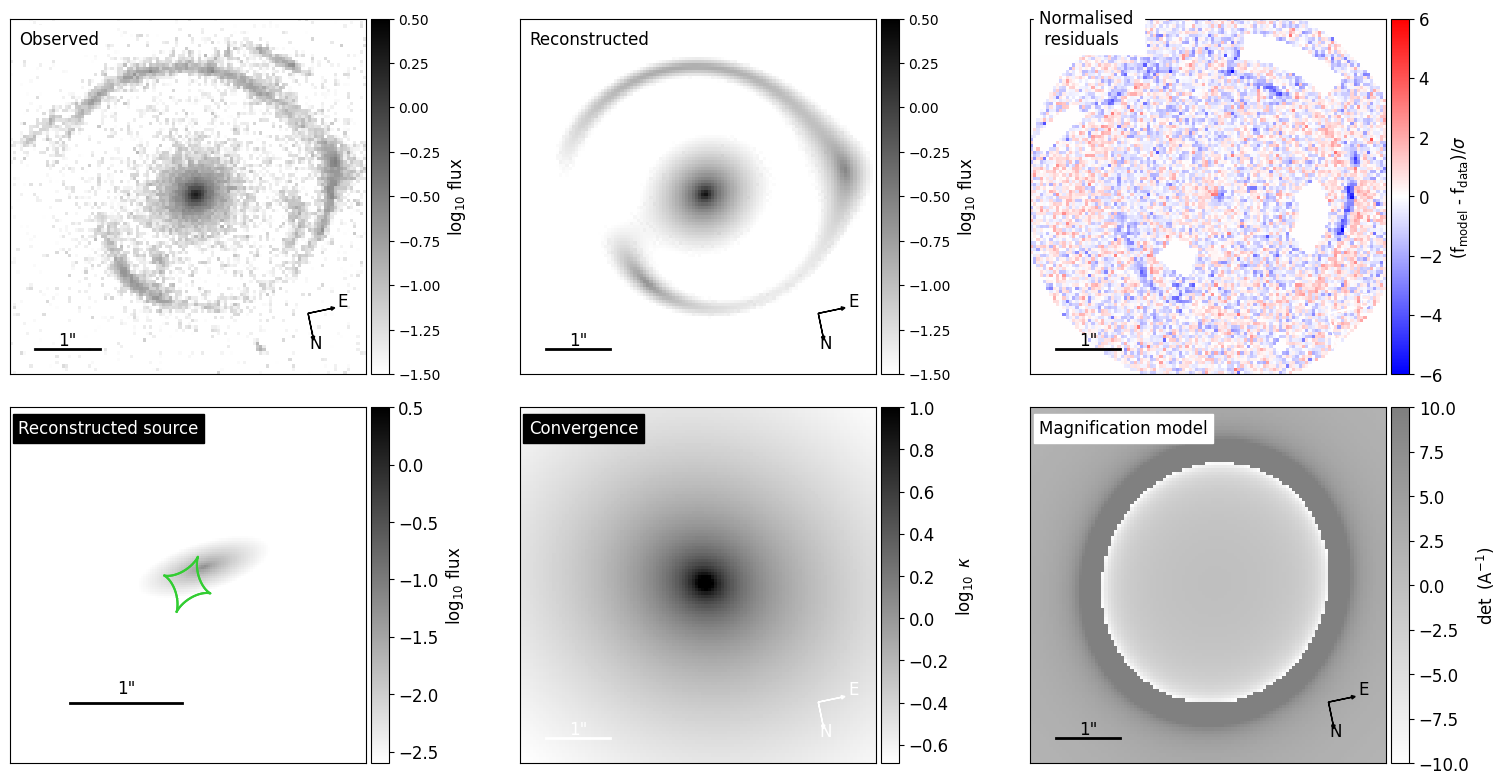

{'kwargs_lens': [{'theta_E': 1.9491427534406187,
   'gamma': 2.07747239760956,
   'e1': 0.02504667069443164,
   'e2': 0.055104226119863105,
   'center_x': 0.08527742818177848,
   'center_y': 0.009585288394106009},
  {'gamma_ext': 0.10048875846208111,
   'psi_ext': 0.5735628617185664,
   'ra_0': 0,
   'dec_0': 0}],
 'kwargs_source': [{'amp': 9.031338513622842,
   'R_sersic': 0.3113723732151225,
   'n_sersic': 1.7900451577087397,
   'e1': 0.4660009119466107,
   'e2': -0.09548668258566845,
   'center_x': 0.2573869736176571,
   'center_y': -0.11957560701010572}],
 'kwargs_lens_light': [{'amp': 18.731486257009553,
   'R_sersic': 0.7666534131329438,
   'n_sersic': 3.6179241633767583,
   'e1': 0.04573599040195959,
   'e2': -0.04490273914107241,
   'center_x': 0.08527742818177848,
   'center_y': 0.009585288394106009}],
 'kwargs_ps': [],
 'kwargs_special': {},
 'kwargs_extinction': [],
 'kwargs_tracer_source': []}

In [35]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                      arrow_size=0.01, cmap_string='gray_r',
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )

f, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)

# produce model data
model = MultiBandImageReconstruction(multi_band_list_out, kwargs_model, kwargs_result)
recon_F200LP = model.model_band_list[0]._model
image_data = kwargs_data_F200LP['image_data']

obs = axes[0,0].imshow(np.log10(image_data), origin='lower', cmap='gray_r',vmin=-1.5,vmax= 0.5)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
divider1 = make_axes_locatable(axes[0,0])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cbar1 = plt.colorbar(obs, cax=cax1)
cbar1.set_ticks(np.arange(-1.5,0.75,0.25))
cbar1.ax.set_ylabel('log$_{10}$ flux', fontsize=12)
plot_util.coordinate_arrows(axes[0,0], 110, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)
plot_util.scale_bar(axes[0,0], 110, dist=20, text='1"', font_size=12, color='k')
plot_util.text_description(axes[0,0], 110,text='Observed',color="k",backgroundcolor="w",font_size=12)

recon = axes[0,1].imshow(np.log10(recon_F200LP), origin='lower', cmap='gray_r',vmin=-1.5,vmax= 0.5)
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
divider2 = make_axes_locatable(axes[0,1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cbar2 = plt.colorbar(recon, cax=cax2)
cbar2.set_ticks(np.arange(-1.5,0.75,0.25))
cbar2.ax.set_ylabel('log$_{10}$ flux', fontsize=12)
plot_util.coordinate_arrows(axes[0,1], 110, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)
plot_util.scale_bar(axes[0,1], 110, dist=20, text='1"', font_size=12, color='k')
plot_util.text_description(axes[0,1], 110,text='Reconstructed',color="k",backgroundcolor="w",font_size=12)

modelPlot.normalized_residual_plot(ax=axes[0,2],font_size=12, v_min=-6, v_max=6, text='Normalised \n residuals')
modelPlot.source_plot(ax=axes[1, 0],font_size=12, deltaPix_source=0.02, numPix=160, with_caustics=True,v_min=-2.6,v_max= 0.5,caustic_color="limegreen", center=(kwargs_result['kwargs_lens'][0]['center_x'], kwargs_result['kwargs_lens'][0]['center_y']))
plot_util.scale_bar(axes[1,0], 0.04*200, dist=1, text='1"', font_size=12, color='k')
modelPlot.convergence_plot(ax=axes[1, 1],font_size=12, v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2],font_size=12)

plt.tight_layout()
plt.savefig(fname='results/'+job_name_out[:-8]+'.pdf')
plt.show()

kwargs_result

-1.0951827152109985 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0951827152109985


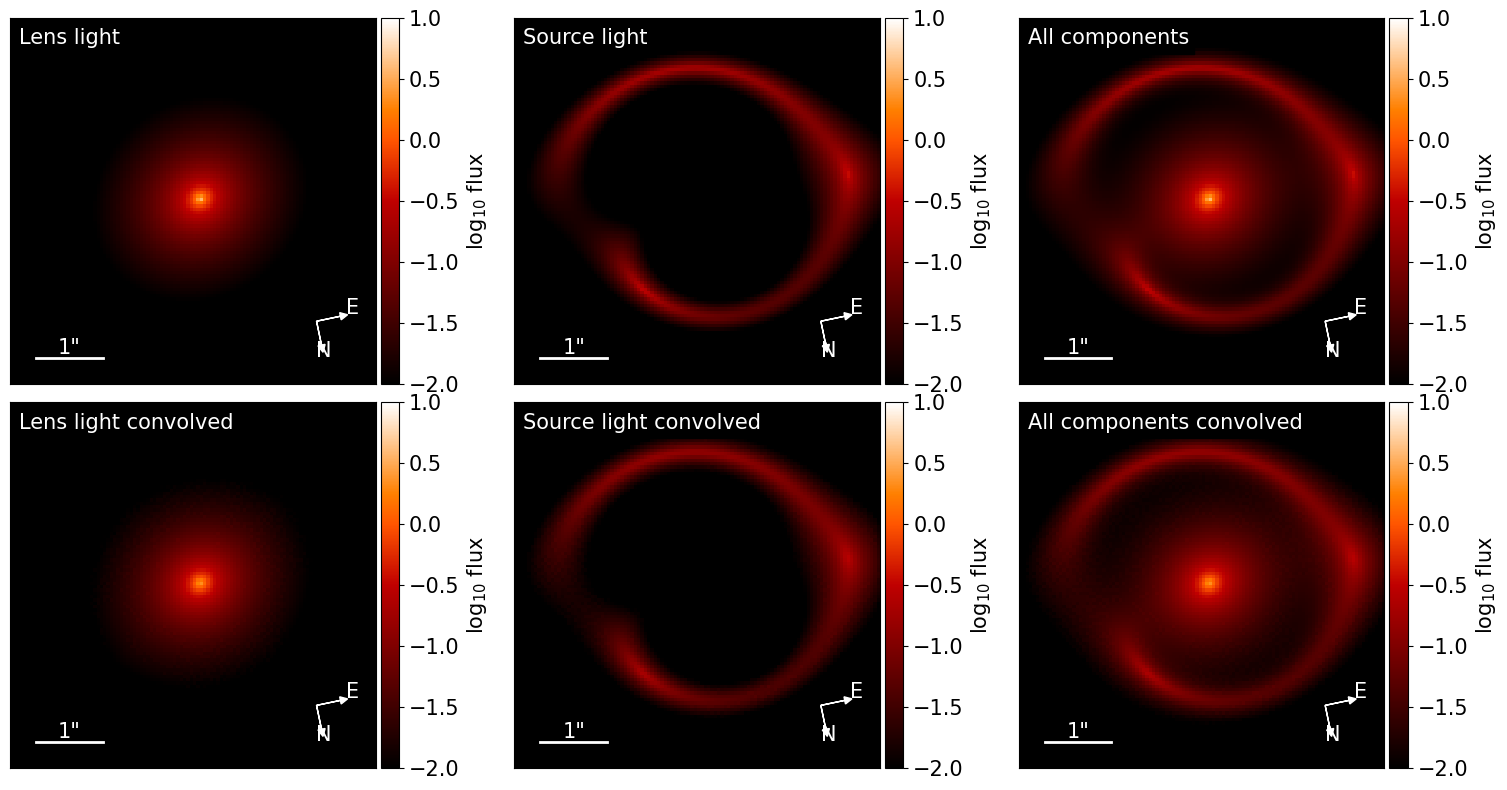

In [38]:
# band index to plot the model breakdown, 0: F140W, 1: F200LP
band_i = 0

lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                     arrow_size=0.02, cmap_string="gist_heat",
                    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'], #kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear', linear_solver = True
                    )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-2,v_max=1) 

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


N_step: 100, N_params: 18
theta_E_lens0 1.949158710355488
gamma_lens0 2.077054791298844
e1_lens0 0.025050413866357406
e2_lens0 0.055144881452461034
gamma_ext_lens1 0.1004966316558433
psi_ext_lens1 0.5737146867957285
R_sersic_source_light0 0.3109272179734175
n_sersic_source_light0 1.782340279616158
e1_source_light0 0.46621383049952086
e2_source_light0 -0.09650171452907817
center_x_source_light0 0.2572836329878993
center_y_source_light0 -0.11948929462967671
R_sersic_lens_light0 0.7666201184798409
n_sersic_lens_light0 3.621386971885256
e1_lens_light0 0.04629101174055941
e2_lens_light0 -0.044890311124837816
center_x_lens_light0 0.08527244904421911
center_y_lens_light0 0.009588530702902989


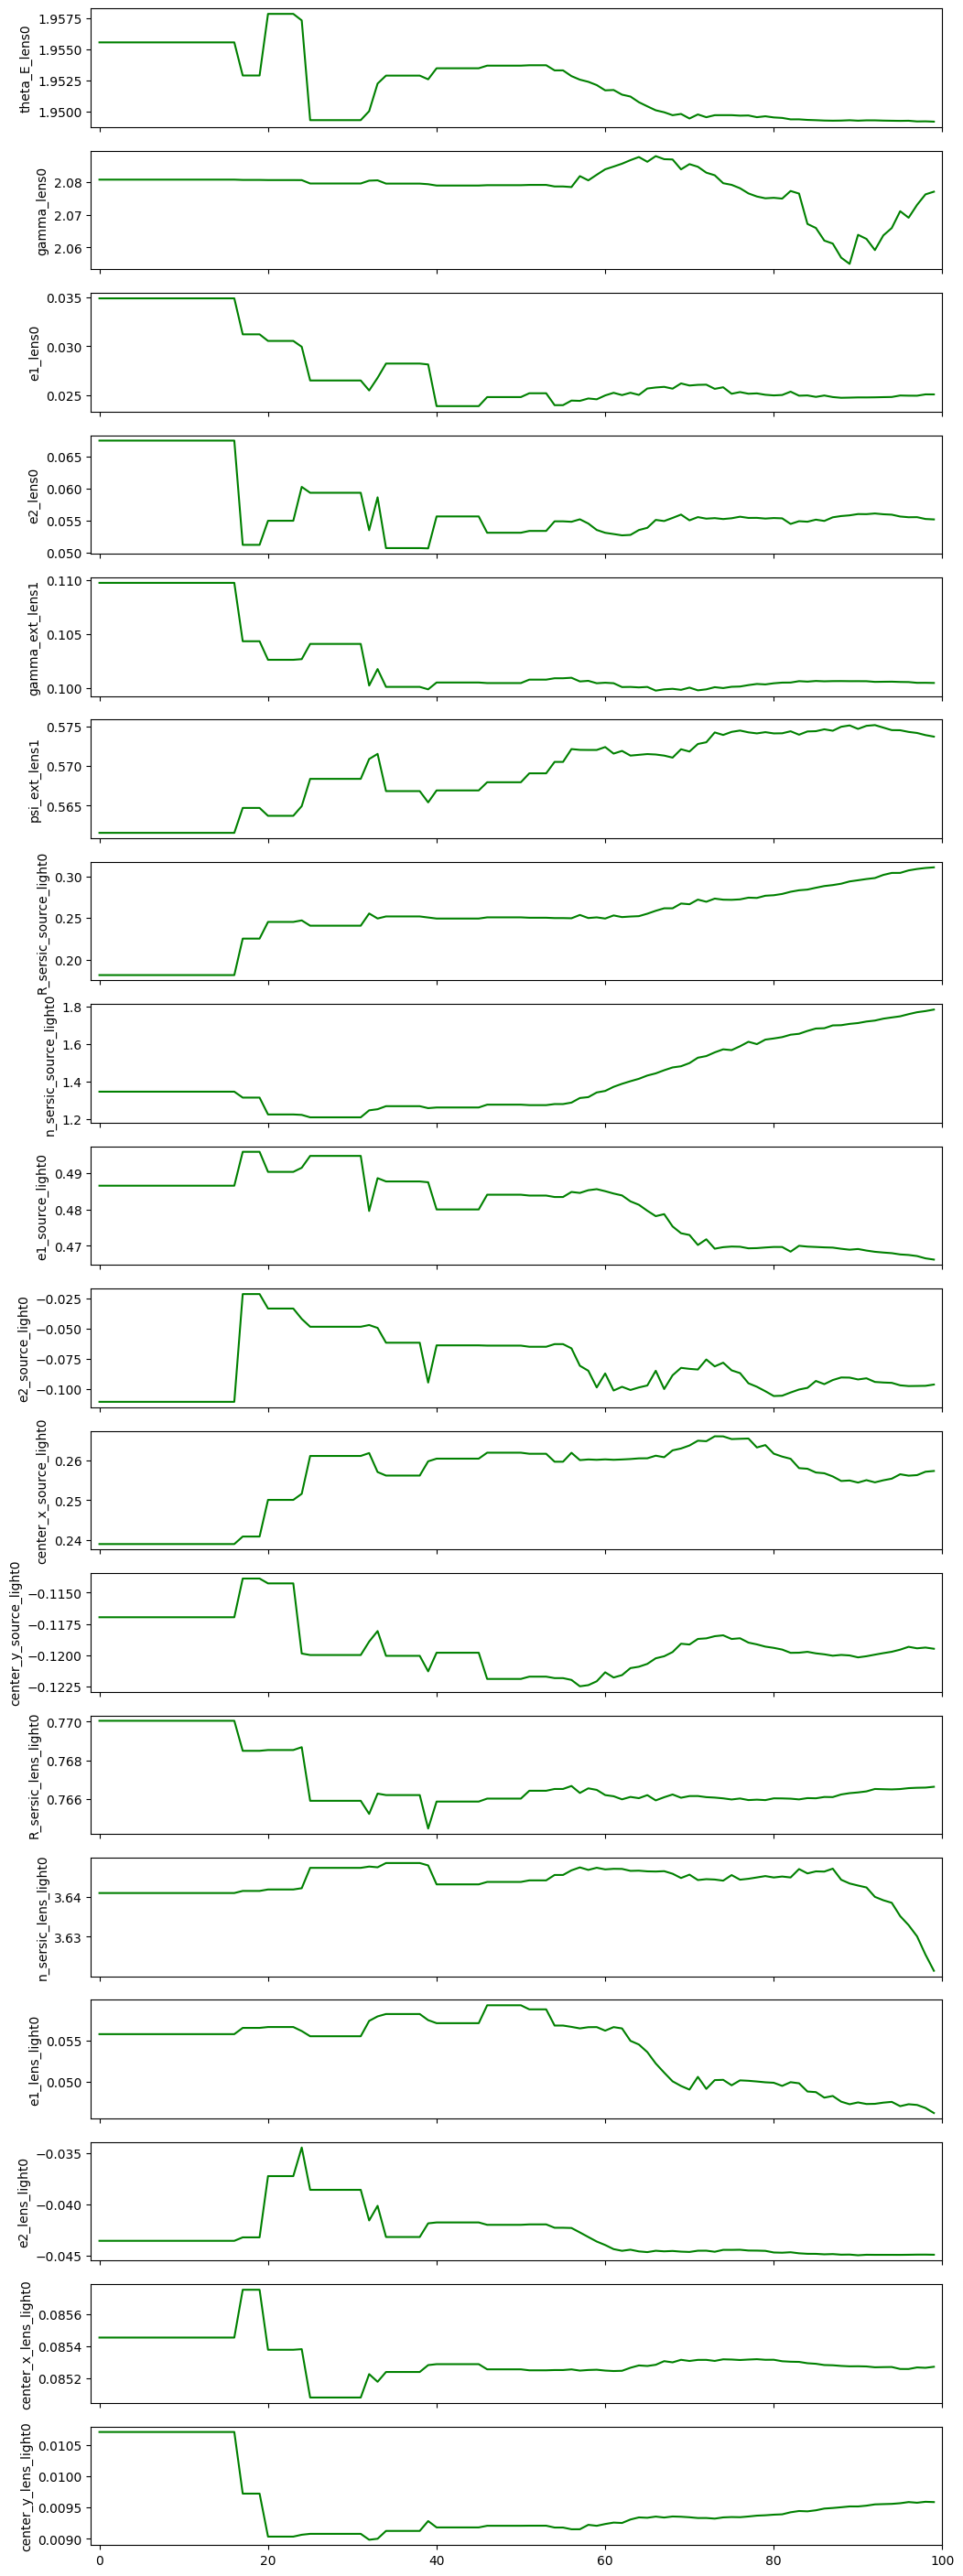

In [37]:
samples_mcmc = []
samples_pso = []

if fit_output[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks, we join the chunks to make the full chain
    mcmc_repeat = 1
      
    for k in range(len(fit_output)-mcmc_repeat, len(fit_output)):
        if samples_mcmc == []:
            samples_mcmc = fit_output[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, fit_output[k][1]))

        param_mcmc = fit_output[k][2]

    MCMC = True

else:
    # if PSO chain was broken in the chunks, we join the chunks to make the full chain
    for k in range(0, len(fit_output)):
        if isinstance(samples_pso, list):  # if empty list
            samples_pso = fit_output[k][1][1]
            samples_pso = np.array(samples_pso)
        else:
            samples_pso = np.vstack((samples_pso, fit_output[k][1][1]))
    
    param_pso = fit_output[-1][2]

    MCMC = False
    
if MCMC:
    n_params = samples_mcmc.shape[1]

    n_walkers = fitting_kwargs_list[-1][1]['walkerRatio'] * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

else:
    n_params = np.shape(samples_pso)[1]

    n_step = np.shape(samples_pso)[0]

    print('N_step: {}, N_params: {}'.format(n_step, n_params))

    chain = np.array(samples_pso)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    last = n_step

    for i in range(n_params):
        print(param_pso[i], chain[-1,i])

        ax[i].plot(chain[:,i], c='g')
        ax[i].set_ylabel(param_pso[i], fontsize=10)
        ax[i].set_xlim(-1, last)

    if True:
        fig.set_size_inches((12., 2*len(param_pso)))
        plt.show()

In [ ]:
# from datetime import date

# # writing comments
# comment = 'Continuing from 07. Not much change and not converged'
# np.savetxt('results/comments/'+'DCLS0353_single_source_F200LP_V5_run_08.txt', [date.today(), comment], fmt='%s')

## MCMC posteriors

In [ ]:
# # only run the below if MCMC used

# sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = fit_output[-1]
    
# print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
# print("parameters in order: ", param_mcmc)
# print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
# import corner

# n, num_param = np.shape(samples_mcmc)
# #plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)

In [ ]:
# n_junk = 100000  # number of initial sample values to discard
# n_display_params = 6  # number of fitted params to plot

# sample = samples_mcmc[n_junk:,:n_display_params]  # selecting relevant sample parameters and values
# col_name = param_mcmc[:n_display_params]
# figure = corner.corner(sample,color='k',
#                        labels=col_name,
#                        title_quantiles=[0.16, 0.5, 0.84],
#                        title_fmt=".3f",
#                        quantiles=[0.16, 0.5, 0.84],
#                        show_titles=True,
#                        smooth=0.5                    
#                        )